In [4]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.metrics import mean_squared_error
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import ssl
from scraperGoogle import scrape

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')
plt.style.use('fivethirtyeight')

df = yf.download("TSLA", start="2022-01-01", end="2022-12-31")
df.index = pd.to_datetime(df.index)
df['Date'] = pd.to_datetime(df.index)


WebDriverException: Message: 'chromedriver' executable needs to be in PATH. Please see https://chromedriver.chromium.org/home


In [12]:
from finvader import finvader
def analyze_sentiment(text):
    scores = finvader(text, 
                  use_sentibignomics = True, 
                  use_henry = True, 
                  indicator = 'compound' )
    return scores

ModuleNotFoundError: No module named 'finvader'

# Autoregression

In [4]:
# from statsmodels.tsa.ar_model import AutoReg
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# df = df['Close']
# X = df.values
# train, test = X[1:len(X)-7], X[len(X)-7:]
# model = AutoReg(train, lags=29)
# model_fit = model.fit()
# print('Coefficients: %s' % model_fit.params)

In [5]:
# make predictions
# predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
#  print('predicted=%f, expected=%f' % (predictions[i], test[i]))
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

# TSS Without Cross Validation

In [6]:
train_df = df.loc[df.index < '2022-09-01']
test_df = df.loc[df.index >= '2022-09-01']

fig, ax = plt.subplots(figsize=(15, 5))
train_df['Close'].plot(ax=ax, label='Training')
test_df['Close'].plot(ax=ax, label='Test')
ax.axvline(x='2022-09-01', c='black', linestyle='--')
ax.legend(['Training Set', 'Testing Set'])
plt.show()

NameError: name 'df' is not defined

In [7]:
pd.options.mode.chained_assignment = None  # default='warn'
train_df['sentiment'] = np.zeros(len(train_df))
train_df['sentiment_volatility'] = np.zeros(len(train_df))
train_df['Date'] = pd.to_datetime(train_df.index)
for i, row in train_df.iterrows():
    score = []
    res = scrape("tesla stock news", 10, str(row['Date']).rsplit(' ')[0], str(row['Date']).rsplit(' ')[0])
    print("+++++++++++")
    # print(str(row['Date']).rsplit(' ')[0], res)
    for topic in res:
        sentiment = analyze_sentiment(topic)
        score.append(sentiment)
    train_df.at[i, 'sentiment'] = np.mean(score)
    train_df.at[i, 'sentiment_volatility'] = np.std(score)
    print(train_df['sentiment'][i], train_df['sentiment_volatility'][i])
train_df.to_csv('./Testing Data/train_df.csv')


NameError: name 'pd' is not defined

In [8]:
test_df['sentiment'] = np.zeros(len(test_df))
test_df['sentiment_volatility'] = np.zeros(len(test_df))
test_df['Date'] = pd.to_datetime(test_df.index)
for i, row in test_df.iterrows():
    score = []
    res = scrape("tesla stock news", 10, str(row['Date']).rsplit(' ')[0], str(row['Date']).rsplit(' ')[0])
    print("+++++++++++")
    for topic in res:
        sentiment = analyze_sentiment(topic)
        print(sentiment, topic)
        score.append(sentiment)
    test_df.at[i, 'sentiment'] = np.mean(score)
    test_df.at[i, 'sentiment_volatility'] = np.std(score)
    print(test_df['sentiment'][i], test_df['sentiment_volatility'][i])
test_df.to_csv('./Testing Data/test_df.csv')

NameError: name 'np' is not defined

In [9]:
train_df = pd.read_csv('./Training Data/train_df.csv')
test_df = pd.read_csv('./Testing Data/test_df.csv')

train_df['sentiment_squared'] = train_df['sentiment']**2
test_df['sentiment_squared'] = test_df['sentiment']**2

df = yf.download("TSLA", start="2022-01-01", end="2022-12-31")
df.index = pd.to_datetime(df.index)
df['Date'] = pd.to_datetime(df.index)


NameError: name 'pd' is not defined

In [10]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Open_{i}'] = df['Open'] - df['Open'].shift(i)
        df[f'sentiment_{i}'] = df['sentiment'] - df['sentiment'].shift(i)
        
    df.dropna(inplace=True)
    return df

train_df['Open_change'] = train_df['Open'] - train_df['Open'].shift(1)
test_df['Open_change'] = test_df['Open'] - test_df['Open'].shift(1)
df['Open_change'] = df['Open'] - df['Open'].shift(1)
train_df = prepare_dataframe_for_lstm(train_df, 4)
test_df = prepare_dataframe_for_lstm(test_df, 4)

NameError: name 'train_df' is not defined

# features = ['Open_2', 'Open_3']

target = 'Open_change'
X_train = train_df[features] 
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

reg = RandomForestRegressor(n_estimators=10000, random_state=42)
reg.fit(X_train, y_train)

# reg = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.01)
# reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=100)

<Axes: >

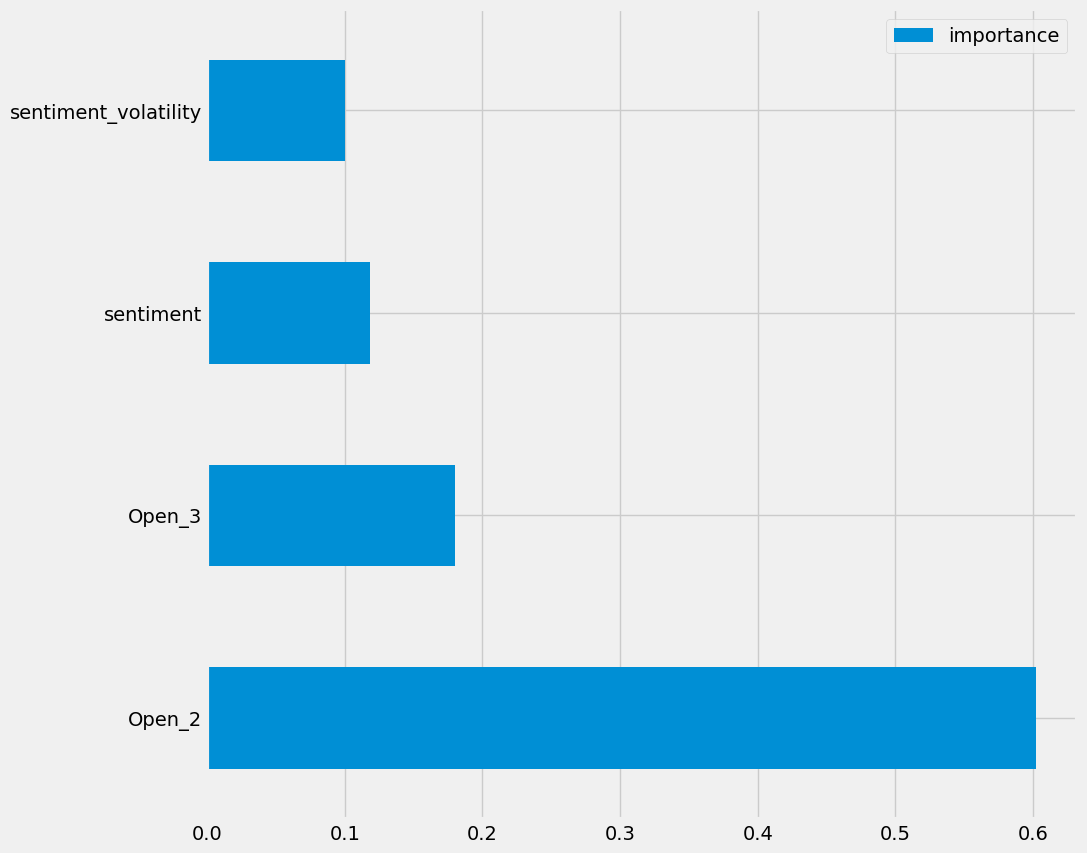

In [417]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.plot(kind='barh', figsize=(10, 10))

In [ ]:
test_df['Prediction'] = reg.predict(X_test)
df = df.merge(test_df[['Prediction']], how='left', left_index=True, right_index=True)


In [ ]:
from sklearn.metrics import r2_score
# test_df = test_df[['Open_change', 'Prediction']]
r_val = r2_score(test_df['Open_change'], test_df['Prediction'])

print("R-squared:", r_val)

In [432]:
df.to_csv('resultant_data/pure_data.csv', index=False)

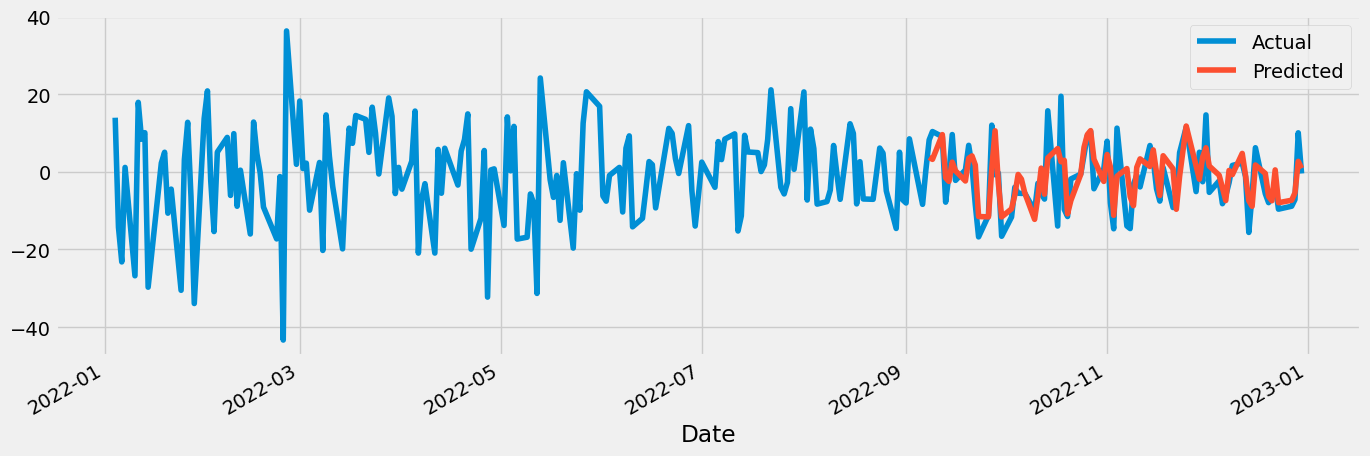

In [421]:
ax = df[['Open_change']].plot(figsize=(15, 5))
df[['Prediction']].plot(ax=ax)
ax.legend(["Actual", "Predicted"])
plt.show()

# TSS With Cross Validation (Testing only)

In [111]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=1)
df = df.sort_index()

In [112]:
def create_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    return df

features = ['year', 'month', 'day', 'dayofweek', 'Open', 'High', 'Low', 'Volume']
target = 'Close'

In [113]:
# fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train_df = create_features(df.iloc[train_idx])
    test_df = create_features(df.iloc[val_idx])

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=2000,
        objective='reg:tweedie', 
        learning_rate=0.01,
        early_stopping_rounds=100,
        max_depth=3,
        )
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    # train['Close'].plot(ax=axs[f old], label='Training Set', title=f'Data Train / Test Split Fold {fold}')
    # test['Close'].plot(ax=axs[fold], label='Test Set')
    # axs[fold].axvline(test.index.min(), color='black', ls='--')
    # fold += 1

[0]	validation_0-tweedie-nloglik@1.5:73.25605	validation_1-tweedie-nloglik@1.5:197.04252
[100]	validation_0-tweedie-nloglik@1.5:32.77532	validation_1-tweedie-nloglik@1.5:80.46598
[200]	validation_0-tweedie-nloglik@1.5:21.99253	validation_1-tweedie-nloglik@1.5:44.32280
[300]	validation_0-tweedie-nloglik@1.5:20.02668	validation_1-tweedie-nloglik@1.5:35.91794
[400]	validation_0-tweedie-nloglik@1.5:19.74082	validation_1-tweedie-nloglik@1.5:34.08120
[500]	validation_0-tweedie-nloglik@1.5:19.70149	validation_1-tweedie-nloglik@1.5:33.68142
[600]	validation_0-tweedie-nloglik@1.5:19.69609	validation_1-tweedie-nloglik@1.5:33.57441
[700]	validation_0-tweedie-nloglik@1.5:19.69532	validation_1-tweedie-nloglik@1.5:33.53750
[800]	validation_0-tweedie-nloglik@1.5:19.69519	validation_1-tweedie-nloglik@1.5:33.52274
[900]	validation_0-tweedie-nloglik@1.5:19.69515	validation_1-tweedie-nloglik@1.5:33.51783
[1000]	validation_0-tweedie-nloglik@1.5:19.69514	validation_1-tweedie-nloglik@1.5:33.51421
[1100]	val

In [114]:
scores

[15.077565318042568,
 17.1029217373159,
 14.501139992307396,
 3.136722442640417,
 48.488649446412175]

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.plot(kind='barh', figsize=(10, 10))

In [ ]:
test_df['Prediction'] = reg.predict(X_test)
df = df.merge(test_df[['Prediction']], how='left', left_index=True, right_index=True)

In [ ]:
ax = df[['Close']].plot(figsize=(15, 5))
df[['Prediction']].plot(ax=ax, style='.')
ax.legend(["Actual", "Predicted"])
plt.show()

In [2]:
%pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 238.4 kB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys
print(sys.executable)

/Users/ken/opt/anaconda3/bin/python


In [3]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 5.6 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Created wheel for peewee: filename=peewee-3.17.0-cp39-cp39-macosx_10_9_x86_64.whl size=250998 sha256=fe21e0c24901884ac477de28ffdbad808a3df2e15cfd0de986acf116b8643f56
  Stored in directory: /Users/ken/Library/Caches/pip/wheels/77/6b/dc/722aee2a5d46a021ab67564c9d3d5536c3bd9577fcdc3a5aeb
Successfully built peewee
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1
ERROR: pip's dependency resolver does not currently take into account all t

In [2]:
pip install yfinance


[notice] A new release of pip is available: 23.0 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 503.8 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0
    Uninstalling pip-23.0:
      Successfully uninstalled pip-23.0
Note: you may need to restart the kernel to use updated packages.
